# 07 - Basic Normalizing Flow Training and Sampling
This notebook is the first in a series of InvertibleNetworks.jl. Here we will layout the basic theory behind Normalizing Flows (NFs) and how to use the implementations in InvertibleNetworks.jl to train and sample from a basic Normalizing Flow using the [GLOW](https://proceedings.neurips.cc/paper/2018/file/d139db6a236200b21cc7f752979132d0-Paper.pdf) architecture.

The GLOW architecture implements:
* Affine couplying layer from Real-NVP
* Ability to activate multiscale for efficient training and compressive behavior in latent $z$ 
* ActNorms for stable training   
* 1x1 Convolutions for channel mixing between affine couplying layers  



In [ ]:
import Pkg; Pkg.develop("InvertibleNetworks") #note only need to run once to install
import Pkg; Pkg.add("Flux")                   #note only need to run once to install

In [1]:
using InvertibleNetworks
using LinearAlgebra
using PyPlot
using Flux

import Flux.Optimise: ADAM, update!

PyPlot.rc("font", family="serif"); 

## Target distribution

For this example, we will learn to sample from the 2-D Rosenbrock distribution. Accessible in InvertibleNetworks.jl
using its colloquial name: the "banana" distribution

In [2]:
n_train = 60000;
X_train = sample_banana(n_train);
size(X_train) #(nx, ny, n_channels, n_samples) Note: we put 2 dimensions as channels

(1, 1, 2, 60000)

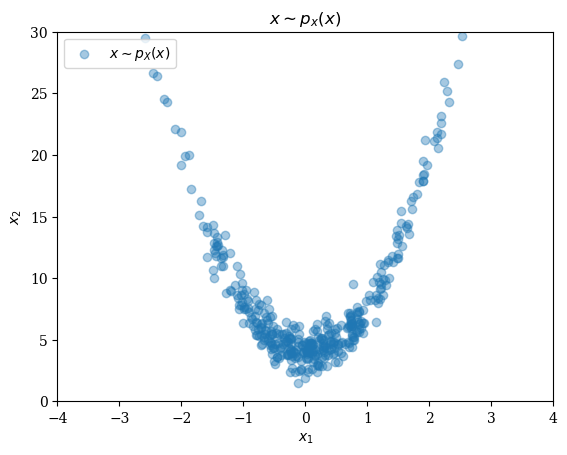

In [4]:
fig = figure(); title(L"x \sim p_x(x)")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();

## Change of variables formula

$$p_x(x) = p_z(f_\theta(x)) \, |\det \frac{\partial f_\theta}{\partial x}|$$

This formula allows us to evaluate the density of a sample under a monotone function $f_{\theta} : \mathbf{X} \rightarrow
 \mathbf{Z}$. 
 
 This density estimation is what gives us a maximum likelihood framework for training our parameterized functions $f_{\theta}$ which we will parameterize as a Normalizing Flow $G_{\theta}$. 

## Training a normalizing flow 

write out the negative log likelihood (nll)
 
NF training is based on likelihood maximization of the parameterized model $f_{\theta}$ under the log likelihood of samples from the data distribution X: 

$$\underset{\mathbf{\theta}}{\operatorname{argmax}} \mathbb E_{{x} \sim p(x)} [\log p(x)]. $$.

We approximate the expectation with Monte Carlo samples from the training dataset:

$$\underset{\mathbf{\theta}}{\operatorname{argmax}}   \frac{1}{N} \sum_{x \in X_{train}} \log p(x). $$

We make this a minimization problem by looking at the negative loglikelihood and then the change of variabes formula makes this:

$$\underset{\mathbf{\theta}}{\operatorname{argmin}}   \frac{1}{N} \sum_{x \in X_{train}} -\log p(x) = \underset{\mathbf{\theta}}{\operatorname{argmin}}   \frac{1}{N} \sum_{x \in X_{train}}  [\frac{1}{2}\|G_\theta({x})\|_2^2 - \log | \det \nabla_{x} G_\theta(x) | ]  $$

This means that you apply your network to your data $\hat z = G_\theta(x)$ and want $\hat z$ to look like Normal noise. The log det of the jacobian term is making sure that we learn a distribution. 

Calling ``G.backward`` will set all the gradients of the trainable parameters in G. We can access these parameters and their gradients with ``get_params`` and update them with the optimizer of our choice.

Note: since the network is invertible we do not need to save intermediate states to calculate the gradient. Instead, we only provide the ``G.backward`` function with the final output Z and it will recalculate the intermediate states to calculate the gradients at each layer while backpropagating the residual dZ. 

In [5]:
function loss(G, X)
    batch_size = size(X)[end] 
    
    Z, lgdet = G.forward(X)
    
    l2_loss = 0.5*norm(Z)^2 / batch_size  #likelihood under Normal Gaussian training 
    dZ = Z / batch_size                   #gradient under Normal Gaussian training
    
    G.backward(dZ, Z)  #sets gradients of G wrt output and also logdet terms
    
    return (l2_loss, lgdet)
end

loss (generic function with 1 method)

In [18]:
nx          = 1
ny          = 1

#network architecture
n_in        = 2 #put 2d variables into 2 channels
n_hidden    = 64
levels_L    = 1
flowsteps_K = 10

G = NetworkGlow(n_in, n_hidden, levels_L, flowsteps_K;)
#G = G |> gpu 

#training parameters
batch_size = 300
maxiter    = cld(n_train, batch_size)

lr = 1f-3
opt = ADAM(lr)

loss_l2_list    = zeros(maxiter)
loss_lgdet_list = zeros(maxiter)

for j = 1:maxiter
    idx = ((j-1)*batch_size+1):(j*batch_size)
    
    X = X_train[:,:,:,idx]
    #x = x |> gpu
    
    losses = loss(G, X) #sets gradients of G
    
    loss_l2_list[j]    = losses[1]
    loss_lgdet_list[j] = losses[2]
    
    print("Iter : iteration=", j, "/", maxiter, ", batch=", 
            "; f l2 = ",   loss_l2_list[j], 
            "; f lgdet = ",loss_lgdet_list[j], 
            "; f nll objective = ",loss_l2_list[j] - loss_lgdet_list[j], "\n")
     
    for p in get_params(G) 
        update!(opt,p.data,p.grad)
    end
end

Iter : iteration=1/200, batch=; f l2 = 0.6156622823079427; f lgdet = -2.4117376804351807; f nll objective = 3.0273999627431234
Iter : iteration=2/200, batch=; f l2 = 0.670151621500651; f lgdet = -2.1191811561584473; f nll objective = 2.7893327776590984
Iter : iteration=3/200, batch=; f l2 = 1.5733008829752604; f lgdet = -1.8144826889038086; f nll objective = 3.387783571879069
Iter : iteration=4/200, batch=; f l2 = 1.057926025390625; f lgdet = -1.7792675495147705; f nll objective = 2.8371935749053954
Iter : iteration=5/200, batch=; f l2 = 1.64149658203125; f lgdet = -1.622065544128418; f nll objective = 3.263562126159668
Iter : iteration=6/200, batch=; f l2 = 1.1578370157877604; f lgdet = -1.7393757104873657; f nll objective = 2.897212726275126
Iter : iteration=7/200, batch=; f l2 = 0.7895686340332031; f lgdet = -1.8071377277374268; f nll objective = 2.5967063617706296
Iter : iteration=8/200, batch=; f l2 = 0.7892339579264323; f lgdet = -1.8241080045700073; f nll objective = 2.613341962

Iter : iteration=66/200, batch=; f l2 = 0.828073018391927; f lgdet = -0.7811886668205261; f nll objective = 1.609261685212453
Iter : iteration=67/200, batch=; f l2 = 0.8321661376953124; f lgdet = -0.8256163597106934; f nll objective = 1.6577824974060058
Iter : iteration=68/200, batch=; f l2 = 0.9725849405924479; f lgdet = -0.6340190172195435; f nll objective = 1.6066039578119913
Iter : iteration=69/200, batch=; f l2 = 0.9932353719075521; f lgdet = -0.5245050191879272; f nll objective = 1.5177403910954794
Iter : iteration=70/200, batch=; f l2 = 1.0746009318033853; f lgdet = -0.5944280624389648; f nll objective = 1.6690289942423502
Iter : iteration=71/200, batch=; f l2 = 1.0137180582682292; f lgdet = -0.6400721073150635; f nll objective = 1.6537901655832927
Iter : iteration=72/200, batch=; f l2 = 1.0933741251627604; f lgdet = -0.5780508518218994; f nll objective = 1.6714249769846599
Iter : iteration=73/200, batch=; f l2 = 1.2536686197916667; f lgdet = -0.43029794096946716; f nll objectiv

Iter : iteration=130/200, batch=; f l2 = 0.8634701538085937; f lgdet = -0.34937262535095215; f nll objective = 1.212842779159546
Iter : iteration=131/200, batch=; f l2 = 0.8310887654622395; f lgdet = -0.4707818031311035; f nll objective = 1.3018705685933432
Iter : iteration=132/200, batch=; f l2 = 0.8500223795572917; f lgdet = -0.35370612144470215; f nll objective = 1.2037285010019938
Iter : iteration=133/200, batch=; f l2 = 1.0946506754557292; f lgdet = -0.234616219997406; f nll objective = 1.3292668954531353
Iter : iteration=134/200, batch=; f l2 = 0.8574966430664063; f lgdet = -0.4648172855377197; f nll objective = 1.3223139286041259
Iter : iteration=135/200, batch=; f l2 = 0.9800347900390625; f lgdet = -0.29091835021972656; f nll objective = 1.270953140258789
Iter : iteration=136/200, batch=; f l2 = 1.15577880859375; f lgdet = -0.2823472023010254; f nll objective = 1.4381260108947753
Iter : iteration=137/200, batch=; f l2 = 1.069815877278646; f lgdet = -0.41917306184768677; f nll o

Iter : iteration=194/200, batch=; f l2 = 0.9242781575520833; f lgdet = -0.2230493426322937; f nll objective = 1.147327500184377
Iter : iteration=195/200, batch=; f l2 = 1.0736142985026043; f lgdet = -0.22020244598388672; f nll objective = 1.293816744486491
Iter : iteration=196/200, batch=; f l2 = 1.081029764811198; f lgdet = -0.24489271640777588; f nll objective = 1.3259224812189738
Iter : iteration=197/200, batch=; f l2 = 0.8144991556803386; f lgdet = -0.17776060104370117; f nll objective = 0.9922597567240398
Iter : iteration=198/200, batch=; f l2 = 0.9912981160481771; f lgdet = -0.1707046627998352; f nll objective = 1.1620027788480123
Iter : iteration=199/200, batch=; f l2 = 1.4158399454752604; f lgdet = -0.19210177659988403; f nll objective = 1.6079417220751444
Iter : iteration=200/200, batch=; f l2 = 1.1154739379882812; f lgdet = -0.22916805744171143; f nll objective = 1.3446419954299926


## Check training objective log 
There are various ways to train a NF:
- train your network to convergence of objective
- use earlystopping to prevent overfitting 
- check normality of $\hat z = G_{\theta}(x)$ with qq plots 
- as a heuristic simply observe $\hat z = G_{\theta}(x)$ until it looks normal under the eyeball norm. 

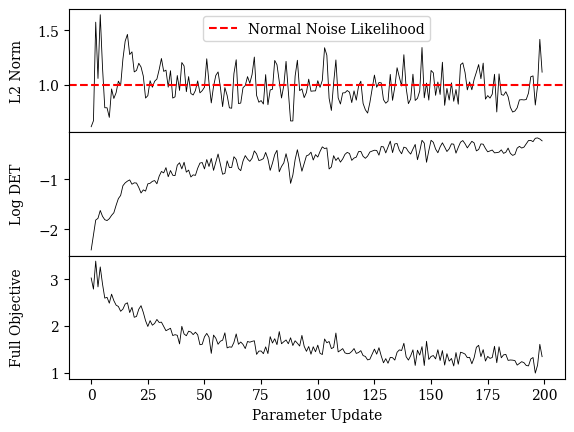

PyObject Text(0.5, 24.0, 'Parameter Update')

In [19]:
gt_l2 = 0.5*nx*ny*n_in #likelihood of gaussian noise

fig, axs = subplots(3, 1, sharex=true)
fig.subplots_adjust(hspace=0)

axs[1].plot(loss_l2_list, color="black", linewidth=0.6); 
axs[1].axhline(y=gt_l2,color="red",linestyle="--",label="Normal Noise Likelihood")
axs[1].set_ylabel("L2 Norm")
axs[1].yaxis.set_label_coords(-0.09, 0.5)
axs[1].legend()

axs[2].plot(loss_lgdet_list, color="black", linewidth=0.6); 
axs[2].set_ylabel("Log DET") 
axs[2].yaxis.set_label_coords(-0.09, 0.5) 

axs[3].plot(loss_l2_list - loss_lgdet_list, color="black", linewidth=0.6); 
axs[3].set_ylabel("Full Objective") 
axs[3].yaxis.set_label_coords(-0.09, 0.5)
axs[3].set_xlabel("Parameter Update") 

## Testing a Normalizing Flow 
Since we have access to $p_x(x)$ we can verify that generative samples from our trained network  $\hat x = G^{-1}_\theta(z)$  look like they come from $p_x(x)$

We can verify this visually (easy since this is a 2D dataset) and under the ground truth density of $p_x(x)$.

Take samples from $z \sim N(0,I) $

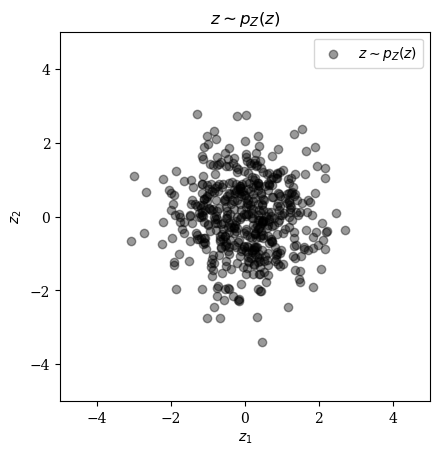

In [20]:
num_test_samples = 500;
Z_test = randn(Float32,nx,ny,n_in, num_test_samples);

fig = figure(); title(L"z \sim p_{Z}(z)")
ax = fig.add_subplot(111);
scatter(Z_test[1,1,1,:], Z_test[1,1,2,:]; alpha=0.4, color="black", label = L"z \sim p_{Z}(z)");
xlabel(L"z_1"); ylabel(L"z_2");
xlim(-5,5); ylim(-5,5);
legend(); 
ax.set_aspect(1);

Pass Normal samples $z \sim N(0,I)$ through the inverse network $\hat x = G^{-1}_\theta(z)$ 

In [21]:
X_test = G.inverse(Z_test);

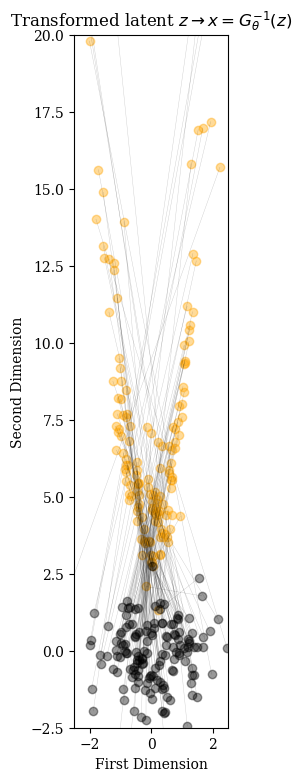

In [22]:
trans_num = 150
start_points = [(Z_test[1,1,1,i], Z_test[1,1,2,i]) for i in 1:trans_num]
end_points = [(X_test[1,1,1,i], X_test[1,1,2,i]) for i in 1:trans_num]

fig = figure(figsize=(7,9)); title(L"Transformed latent $z \rightarrow x=G^{-1}_\theta(z)$");
ax = fig.add_subplot(111)

for line in zip(start_points, end_points)
    plot([line[1][1],line[2][1]], [line[1][2] ,line[2][2]], alpha=0.2, linewidth=0.3, color="black")
    scatter(line[1][1], line[1][2], marker="o",alpha=0.4, color="black")
    scatter(line[2][1], line[2][2], marker="o",alpha=0.4, color="orange")
end
xlabel("First Dimension"); ylabel("Second Dimension");
ylim(-2.5,20); xlim(-2.5,2.5); ax.set_aspect(1)

Visually compare generative samples with samples from the ground truth density $x \sim p_x(x) $

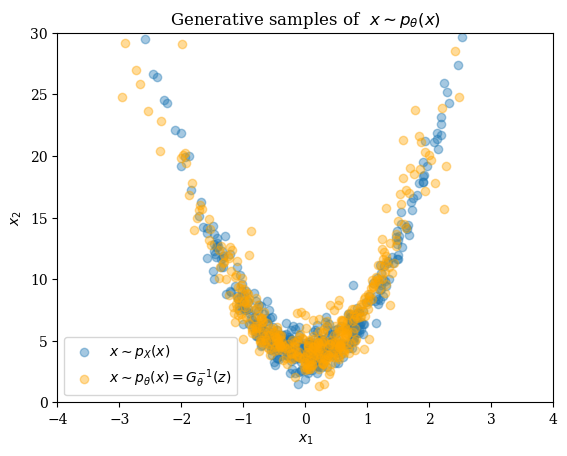

In [23]:
fig = figure(); title(L"Generative samples of  $x \sim p_{\theta}(x)$")
scatter(X_train[1,1,1,1:400], X_train[1,1,2,1:400]; alpha=0.4, label = L"x \sim p_{X}(x)");
scatter(X_test[1,1,1,1:400], X_test[1,1,2,1:400]; alpha=0.4, color="orange", label = L"x \sim p_{\theta}(x) = G_\theta^{-1}(z)");
xlabel(L"x_1"); ylabel(L"x_2");
xlim(-4,4); ylim(0,30);
legend();